In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [49]:
df = pd.read_csv('train.csv', parse_dates=['date'])
df_finaltest = pd.read_csv('test.csv', parse_dates=['date'])

In [50]:
### Data Pre-processing

In [51]:
df.head()

,date,store,is_state_holiday,is_school_holiday,is_special_day,temperature_max,temperature_min,temperature_mean,sunshine_sum,precipitation_sum,sales,unsold,ordered
0,2021-08-02,store_5,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,1.432748,NaN,NaN
1,2021-08-02,store_8,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,1.253193,NaN,NaN
2,2021-08-02,store_7,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.985026,NaN,NaN
3,2021-08-02,store_4,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.889419,NaN,NaN
4,2021-08-02,store_1,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.572282,NaN,NaN


In [52]:
df.isnull().sum()

date                    0
store                   0
is_state_holiday        0
is_school_holiday       0
is_special_day          0
temperature_max         0
temperature_min         0
temperature_mean        0
sunshine_sum            0
precipitation_sum       0
sales                   0
unsold               1916
ordered              1916
dtype: int64

In [53]:
df.dtypes

date                 datetime64[ns]
store                        object
is_state_holiday             object
is_school_holiday            object
is_special_day               object
temperature_max             float64
temperature_min             float64
temperature_mean            float64
sunshine_sum                  int64
precipitation_sum           float64
sales                       float64
unsold                      float64
ordered                     float64
dtype: object

In [54]:
# Checking for duplicates
df.duplicated(subset=['date', 'store']).sum()

np.int64(0)

In [55]:
min(df['date']), max(df['date'])

(Timestamp('2021-08-02 00:00:00'), Timestamp('2023-11-30 00:00:00'))

In [56]:
df = df.set_index('date')

In [57]:
df_train = df.loc[df.index < '2023-06-01']
df_test = df.loc[df.index > '2023-06-01']

In [58]:
print(len(df_train))
print(len(df_test))

3618
1516


In [59]:
df_try = df_train

In [60]:
df_try.fillna(method='ffill', inplace=True)

C:\Users\Denis\AppData\Local\Temp\ipykernel_476736\2472829603.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_try.fillna(method='ffill', inplace=True)
C:\Users\Denis\AppData\Local\Temp\ipykernel_476736\2472829603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_try.fillna(method='ffill', inplace=True)


In [61]:
# Determine the full range of expected dates
start_date = df_try.index.min()
end_date = df_try.index.max()
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D') # 'D' for daily frequency

# Find the missing dates by finding the difference between the full range and your index
missing_dates = full_date_range.difference(df_try.index)

if not missing_dates.empty:
    print("Missing dates in the data:")
    print(missing_dates)
else:
    print("No missing dates found within the expected range.")

Missing dates in the data:
DatetimeIndex(['2021-12-25', '2021-12-26', '2022-07-27', '2022-12-25'], dtype='datetime64[ns]', freq=None)


In [62]:
def separate_and_explore_variables(df):
    """
    Separates categorical and continuous variables in a DataFrame,
    displays unique values for categorical variables.
    """
    categorical_cols = []
    continuous_cols = []
    
    for col in df.columns:

        if isinstance(df[col].dtype, pd.CategoricalDtype) or df[col].dtype == 'object' or pd.api.types.is_bool_dtype(df[col]):
            categorical_cols.append(col)
            print(f"Unique values for categorical column '{col}':")
            print(df[col].unique())
            print("-" * 30)
        elif pd.api.types.is_numeric_dtype(df[col]):
            continuous_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            continuous_cols.append(col)

            
    return categorical_cols, print('continuous columns are:'),continuous_cols

In [63]:
separate_and_explore_variables(df_train)

Unique values for categorical column 'store':
['store_5' 'store_8' 'store_7' 'store_4' 'store_1' 'store_6' 'store_0'
 'store_3']
------------------------------
Unique values for categorical column 'is_state_holiday':
['normal_day' 'state_holiday' 'day_before' 'day_after']
------------------------------
Unique values for categorical column 'is_school_holiday':
['school_holiday' 'normal_day']
------------------------------
Unique values for categorical column 'is_special_day':
['normal_day' 'special_day' 'day_before']
------------------------------
continuous columns are:


(['store', 'is_state_holiday', 'is_school_holiday', 'is_special_day'],
 None,
 ['temperature_max',
  'temperature_min',
  'temperature_mean',
  'sunshine_sum',
  'precipitation_sum',
  'sales',
  'unsold',
  'ordered'])

In [64]:
### Feature engineering

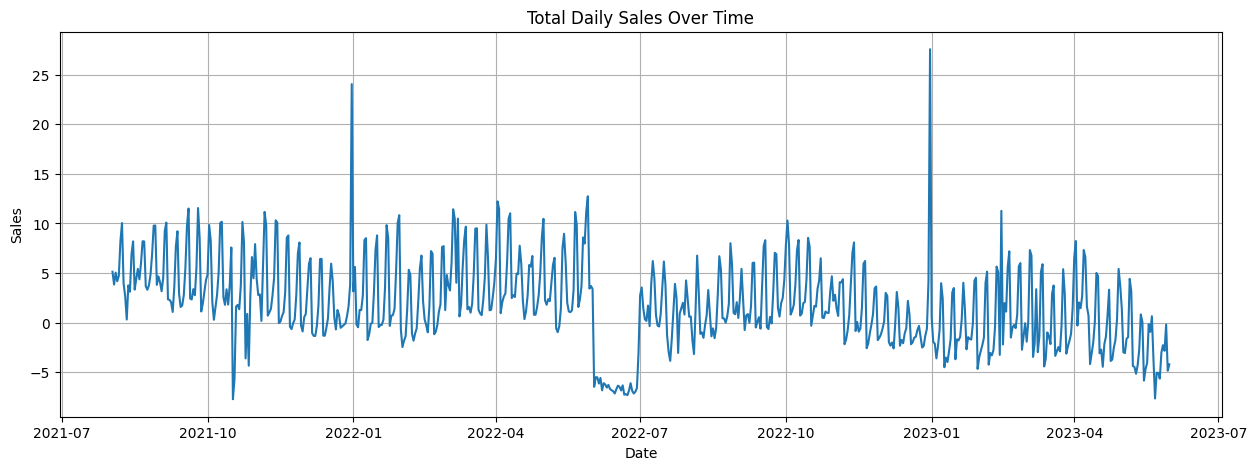

In [65]:
import matplotlib.pyplot as plt

# Aggregate sales across all stores/products
df_daily = df_train.groupby('date')['sales'].sum()

# Plot
plt.figure(figsize=(15,5))
plt.plot(df_daily.index, df_daily.values)
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


In [66]:
#some observations
#Spikes on 2022 jan and 2023 jan, pattern, or anomaly? Should expect for 2024 i guess? This would be considered a TIME STEP FEATURE
# since it completely relies on time marking
# I can see a trend downwards
# I can see a sort of seasonality -- 2 peaks maybe?

In [67]:
#Aggregating by Store
agg_df = df_train.groupby(['date','store']).agg({'sales':'sum'}).reset_index().sort_values(['store','date'])

In [68]:
agg_df.head()

,date,store,sales
2922,2023-03-02,store_0,-1.204614
2929,2023-03-03,store_0,-1.043714
2936,2023-03-04,store_0,-0.733573
2943,2023-03-05,store_0,-1.216273
2950,2023-03-06,store_0,-1.442466


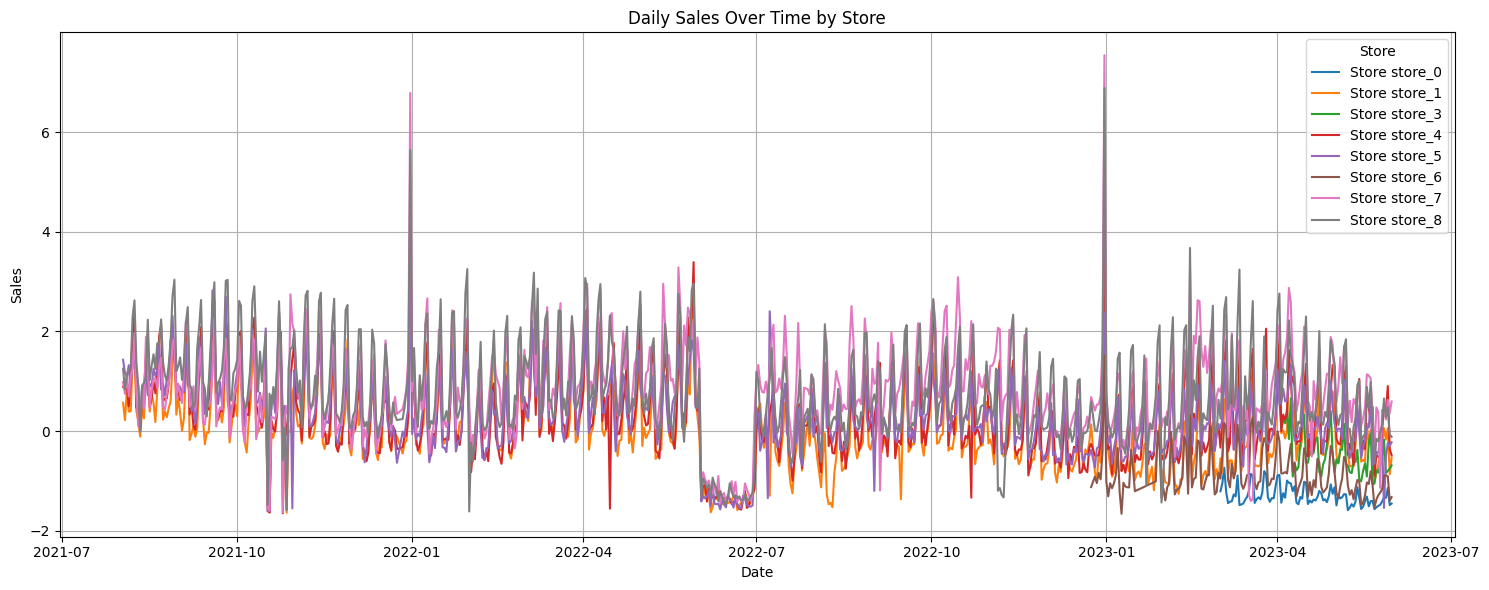

In [69]:

plt.figure(figsize=(15, 6))  # Adjust figure size as needed

for store_id in agg_df['store'].unique():
    store_data = agg_df[agg_df['store'] == store_id]
    plt.plot(store_data['date'], store_data['sales'], label=f'Store {store_id}')

plt.title('Daily Sales Over Time by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend(title='Store')  # Add a legend to identify each store
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

<Axes: title={'center': 'Month of Data'}, xlabel='date'>

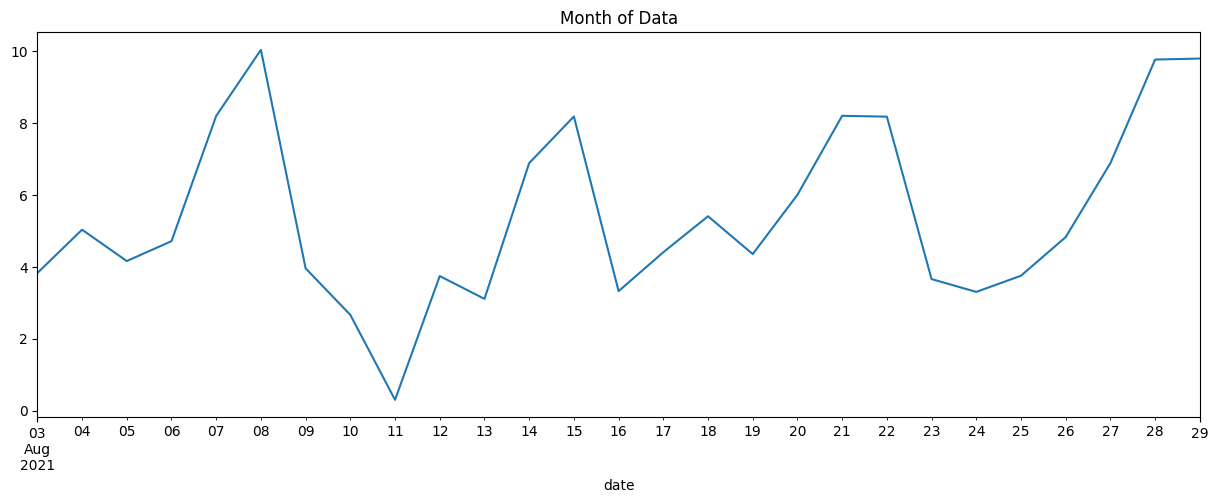

In [70]:
df_daily.loc[(df_daily.index > '2021-08-02') & (df_daily.index < '2021-08-30')].plot(figsize=(15,5), title = 'Month of Data')

In [71]:
## Feature Creation

In [72]:
df_daily.index

DatetimeIndex(['2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09',
               '2021-08-10', '2021-08-11',
               ...
               '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
               '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29',
               '2023-05-30', '2023-05-31'],
              dtype='datetime64[ns]', name='date', length=664, freq=None)

In [73]:
# Create Time Step Features
def create_features(df):
#df_train['hour']=df_train.index.hour
    df['dayofweek']=df.index.dayofweek
    df['month']=df.index.month
    df['quarter']=df.index.quarter
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    return df

In [74]:
df_train

,store,is_state_holiday,is_school_holiday,is_special_day,temperature_max,temperature_min,temperature_mean,sunshine_sum,precipitation_sum,sales,unsold,ordered
date,,,,,,,,,,,,
2021-08-02,store_5,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,1.432748,NaN,NaN
2021-08-02,store_8,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,1.253193,NaN,NaN
2021-08-02,store_7,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.985026,NaN,NaN
2021-08-02,store_4,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.889419,NaN,NaN
2021-08-02,store_1,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.572282,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,store_8,normal_day,normal_day,normal_day,24.9,17.3,22.800000,524,0.0,-0.113292,-1.093579,-0.214086
2023-05-31,store_6,normal_day,normal_day,normal_day,21.3,11.8,17.618182,525,0.0,-1.323540,1.227074,-0.805661
2023-05-31,store_1,normal_day,normal_day,normal_day,24.9,17.3,22.800000,524,0.0,-0.530699,0.186193,-0.283542


In [75]:
## Aggregating Total Sales per day
total_df = df_train.groupby(['date']).agg({'sales':'sum'}).reset_index()

In [76]:
total_df.head()

,date,sales
0,2021-08-02,5.132667
1,2021-08-03,3.833808
2,2021-08-04,5.039392
3,2021-08-05,4.167267
4,2021-08-06,4.719924


In [77]:
total_df = total_df.set_index('date')

In [78]:
# Create Time Step Features
create_features(total_df)

,sales,dayofweek,month,quarter,year,dayofyear
date,,,,,,
2021-08-02,5.132667,0,8,3,2021,214
2021-08-03,3.833808,1,8,3,2021,215
2021-08-04,5.039392,2,8,3,2021,216
2021-08-05,4.167267,3,8,3,2021,217
2021-08-06,4.719924,4,8,3,2021,218
...,...,...,...,...,...,...
2023-05-27,-2.282145,5,5,2,2023,147
2023-05-28,-2.848793,6,5,2,2023,148
2023-05-29,-0.200743,0,5,2,2023,149


Text(0.5, 1.0, 'Sales by day of week')

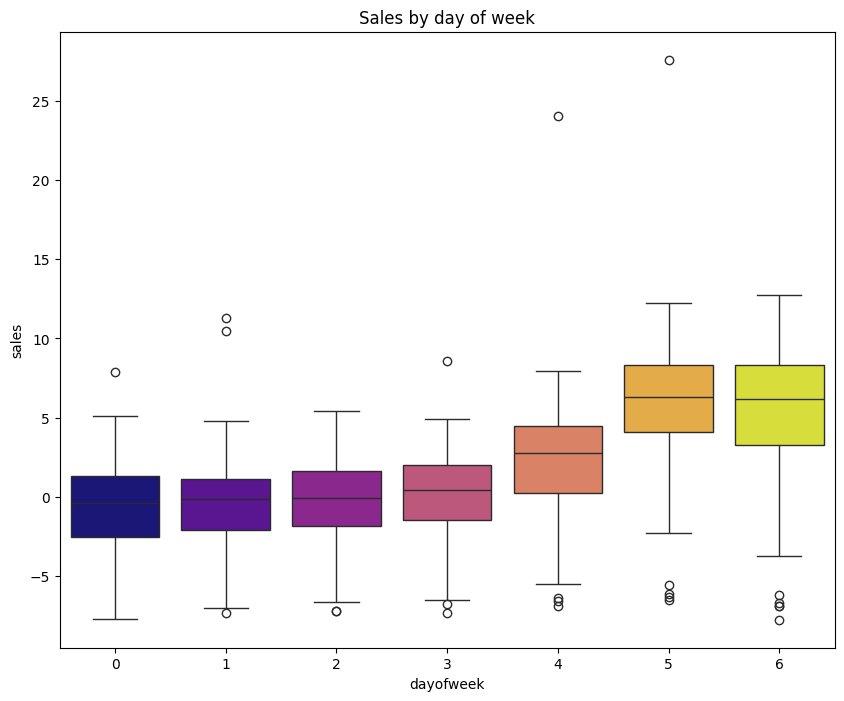

In [79]:
#### plotting sales by day of week
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=total_df, x='dayofweek',y='sales', palette ='plasma', hue = total_df['dayofweek'], legend=False)
ax.set_title('Sales by day of week')

Text(0.5, 1.0, 'Sales by day of month')

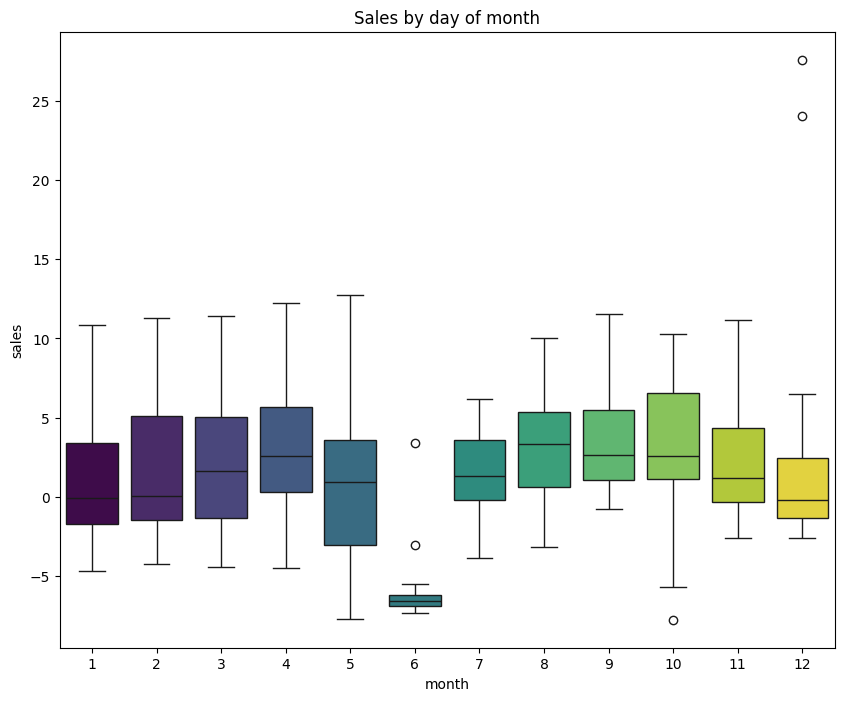

In [80]:
#### plotting sales by month
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=total_df, x='month',y='sales', palette ='viridis', hue = total_df['month'], legend=False)
ax.set_title('Sales by day of month')

Text(0.5, 1.0, 'Sales by day of quarter')

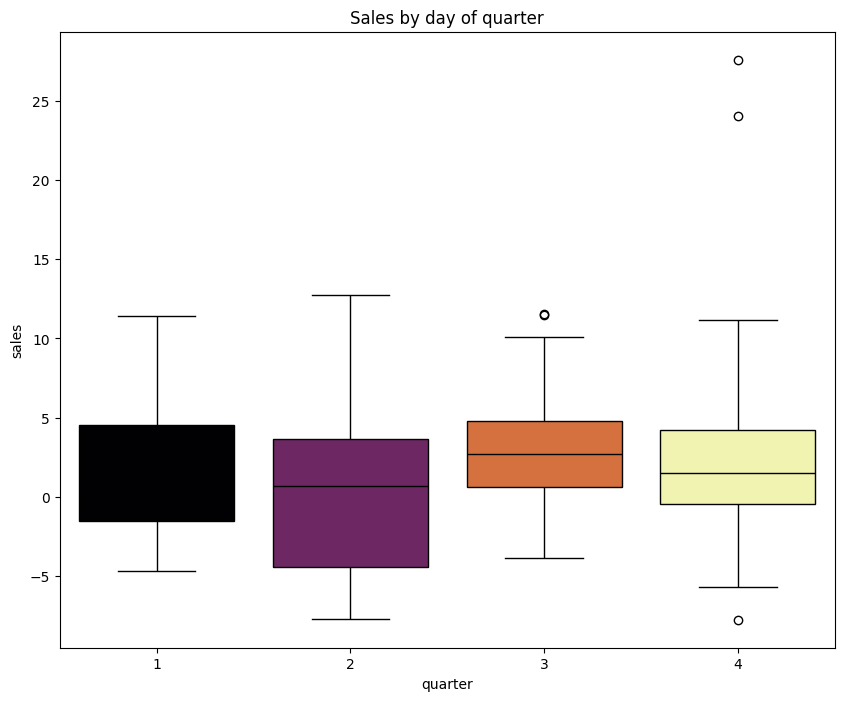

In [81]:
#### plotting sales by quarter
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=total_df, x='quarter',y='sales', palette ='inferno', hue = total_df['quarter'], legend=False)
ax.set_title('Sales by day of quarter')

In [82]:
train = create_features(df_train)
test = create_features(df_test)

FEATURES = ['dayofweek','month','quarter','year','dayofyear']
TARGET = 'sales'

C:\Users\Denis\AppData\Local\Temp\ipykernel_476736\1915408113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek']=df.index.dayofweek
C:\Users\Denis\AppData\Local\Temp\ipykernel_476736\1915408113.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month']=df.index.month
C:\Users\Denis\AppData\Local\Temp\ipykernel_476736\1915408113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [90]:
train

,store,is_state_holiday,is_school_holiday,is_special_day,temperature_max,temperature_min,temperature_mean,sunshine_sum,precipitation_sum,sales,unsold,ordered,dayofweek,month,quarter,year,dayofyear
date,,,,,,,,,,,,,,,,,
2021-08-02,store_5,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,1.432748,NaN,NaN,0,8,3,2021,214
2021-08-02,store_8,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,1.253193,NaN,NaN,0,8,3,2021,214
2021-08-02,store_7,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.985026,NaN,NaN,0,8,3,2021,214
2021-08-02,store_4,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.889419,NaN,NaN,0,8,3,2021,214
2021-08-02,store_1,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.572282,NaN,NaN,0,8,3,2021,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,store_8,normal_day,normal_day,normal_day,24.9,17.3,22.800000,524,0.0,-0.113292,-1.093579,-0.214086,2,5,2,2023,151
2023-05-31,store_6,normal_day,normal_day,normal_day,21.3,11.8,17.618182,525,0.0,-1.323540,1.227074,-0.805661,2,5,2,2023,151
2023-05-31,store_1,normal_day,normal_day,normal_day,24.9,17.3,22.800000,524,0.0,-0.530699,0.186193,-0.283542,2,5,2,2023,151


In [84]:
test

,store,is_state_holiday,is_school_holiday,is_special_day,temperature_max,temperature_min,temperature_mean,sunshine_sum,precipitation_sum,sales,unsold,ordered,dayofweek,month,quarter,year,dayofyear
date,,,,,,,,,,,,,,,,,
2023-06-02,store_1,normal_day,normal_day,normal_day,19.6,12.2,16.909091,472,0.0,0.147879,-0.743775,0.152355,4,6,2,2023,153
2023-06-02,store_4,normal_day,normal_day,normal_day,19.6,12.2,16.909091,472,0.0,0.329766,-1.264215,0.193071,4,6,2,2023,153
2023-06-02,store_6,normal_day,normal_day,normal_day,18.4,11.3,16.472727,476,0.0,-0.868822,2.148510,-0.079964,4,6,2,2023,153
2023-06-02,store_7,normal_day,normal_day,normal_day,19.6,12.2,16.909091,472,0.0,0.905742,-1.187429,0.806201,4,6,2,2023,153
2023-06-02,store_8,normal_day,normal_day,normal_day,19.6,12.2,16.909091,472,0.0,0.665558,NaN,NaN,4,6,2,2023,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,store_1,normal_day,normal_day,normal_day,0.5,-6.2,-2.827273,108,0.0,-0.861827,-0.103889,-0.705069,3,11,4,2023,334
2023-11-30,store_8,normal_day,normal_day,normal_day,0.5,-6.2,-2.827273,108,0.0,0.045276,-0.453693,0.128405,3,11,4,2023,334
2023-11-30,store_0,normal_day,normal_day,normal_day,-1.2,-2.6,-1.909091,0,0.0,-1.465785,-0.760838,-1.509803,3,11,4,2023,334


In [91]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [99]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50,
                      learning_rate = 0.01)
reg.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test,y_test)],
        verbose = True)

[0]	validation_0-rmse:0.99030	validation_1-rmse:1.07995
[1]	validation_0-rmse:0.98485	validation_1-rmse:1.07519
[2]	validation_0-rmse:0.97947	validation_1-rmse:1.07051
[3]	validation_0-rmse:0.97416	validation_1-rmse:1.06589
[4]	validation_0-rmse:0.96893	validation_1-rmse:1.06134
[5]	validation_0-rmse:0.96378	validation_1-rmse:1.05686
[6]	validation_0-rmse:0.95869	validation_1-rmse:1.05245
[7]	validation_0-rmse:0.95368	validation_1-rmse:1.04810
[8]	validation_0-rmse:0.94874	validation_1-rmse:1.04381
[9]	validation_0-rmse:0.94387	validation_1-rmse:1.03960
[10]	validation_0-rmse:0.93907	validation_1-rmse:1.03544
[11]	validation_0-rmse:0.93434	validation_1-rmse:1.03135
[12]	validation_0-rmse:0.92968	validation_1-rmse:1.02732
[13]	validation_0-rmse:0.92509	validation_1-rmse:1.02335
[14]	validation_0-rmse:0.92056	validation_1-rmse:1.01944
[15]	validation_0-rmse:0.91609	validation_1-rmse:1.01559
[16]	validation_0-rmse:0.91170	validation_1-rmse:1.01180
[17]	validation_0-rmse:0.90737	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [101]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])
                

<Axes: title={'center': 'Feature Importance'}>

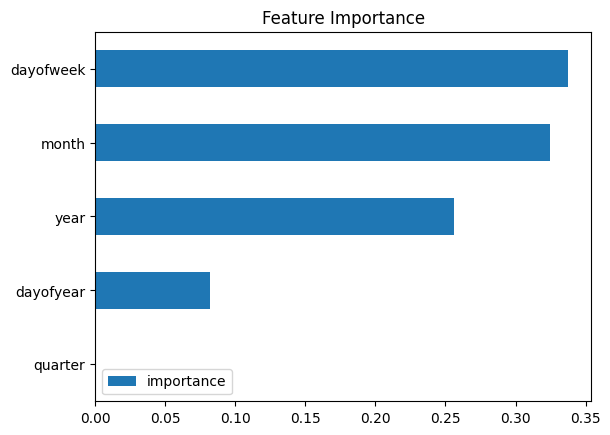

In [102]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

In [104]:
test['prediction'] = reg.predict(x_test)
df = df.merge(test[['prediction']], how='left',left_index=True, right_index=True)

C:\Users\Denis\AppData\Local\Temp\ipykernel_476736\2218512768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(x_test)


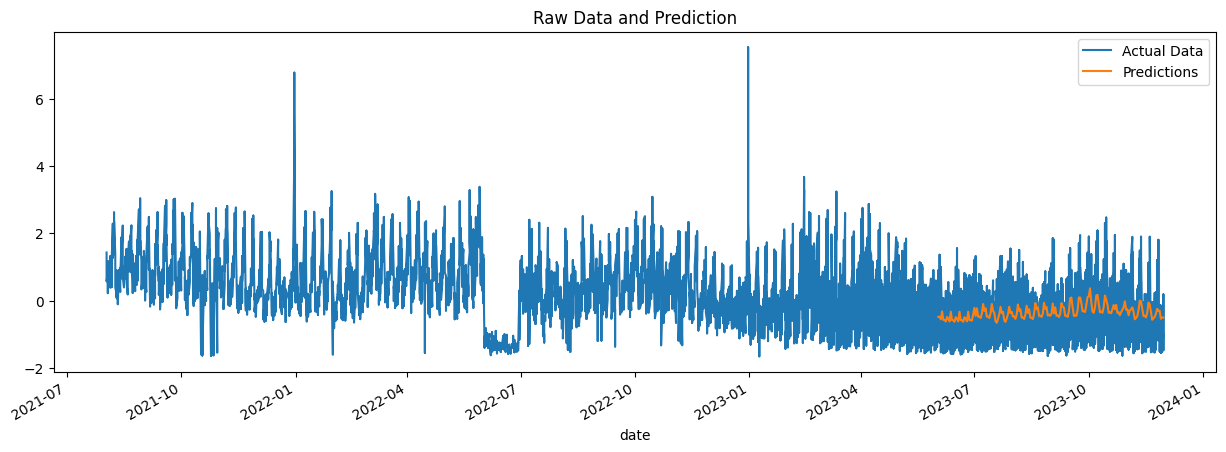

In [108]:
ax = df[['sales']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax)
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [87]:
### Evaluation / Assessment
def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100